In [1]:
import tensorflow as tf

print(len(tf.config.list_physical_devices('GPU'))>0)

True


In [2]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot

In [3]:
(trainx, trainy), (testx, testy) = load_data()

170498071/170498071 [==============================] - 117s 1us/step


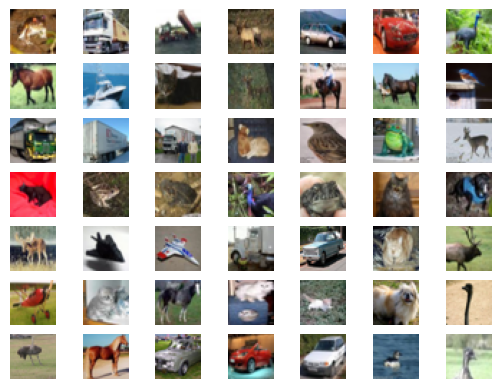

In [4]:
for i in range(49):
    pyplot.subplot(7, 7, 1+i)
    pyplot.axis('off')
    pyplot.imshow(trainx[i])
pyplot.show()

In [7]:
trainx.shape, trainy.shape, testx.shape, testy.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

## Defining Discriminator Model

In [55]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Conv2DTranspose, Reshape
from keras.utils import plot_model
import numpy as np

# Conv2DTranspose will do the opposite of Convolution operation - used for upsampling/increasing 
# spatial dimensions of input

In [13]:
def define_discriminator(in_shape=(32, 32, 3)):
    model = Sequential()
    
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape = in_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(128, (3,3), padding='same', strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(128, (3,3), padding='same', strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))
    
    #downsample
    model.add(Conv2D(256, (3,3), padding='same', strides=(2,2)))
    model.add(LeakyReLU(alpha=0.2))
    
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid')) # -- 0(fake) or 1(real) to tell the image is fake or not.
    
    #compiling model
    optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [14]:
model = define_discriminator()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 256)        

In [15]:
plot_model(model, to_file = 'discriminator_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


![Discriminator Architecture](discriminator_architecture.png)

In [16]:
# Training the discriminator model with real data (it should all real images as 1)

def load_real_samples():
    (trainx,_), (_,_) = load_data()

    X = trainx.astype('float32')
    
    # scale from [0,255] to [-1,1] because we will be using tanh later
    X = (X - 127.5)/127.5
    return X

In [18]:
X = load_real_samples()
X.shape

(50000, 32, 32, 3)

### mini-batch training - each batch containing 128 samples - 64 real, 64 fake

In [38]:
# real samples

def generate_real_samples(dataset, n_samples): # dataset=X, n_samples=64
    
    #choosing random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    
    # retrieving selected images
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    
    return X, y

# returned values X = 64 real images, y = '1' being the label of the images depicting 'real'

In [39]:
#X, y = generate_real_samples(X, 64)

In [40]:
#X.shape, y.shape

((64, 32, 32, 3), (64, 1))

In [42]:
#y.dtype

dtype('float64')

In [45]:
## This is actually done using Generator but this is just to test the discriminator.

# fake samples

def generate_fake_samples(n_samples):
    X = np.random.rand(32 * 32 * 3 * n_samples)
    
    #update to have the range in [-1, 1]
    X = -1 + X * 2
    
    #reshape into batch of colour images
    X = X.reshape((n_samples, 32, 32, 3))
    
    y = np.zeros((n_samples, 1))
    
    return X, y

# returned values X = 64 fake images (noise), y = '0' being the label of the images depicting 'fake'

In [46]:
X, y = generate_fake_samples(64)
print(X.shape, y.shape)
print(y[:10])

(64, 32, 32, 3) (64, 1)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


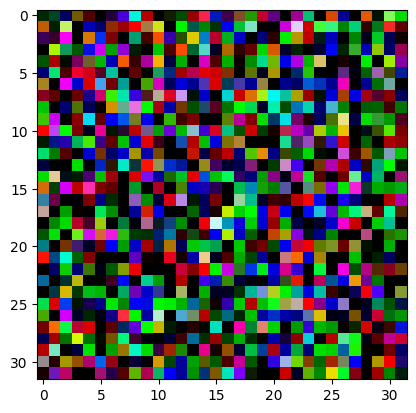

In [47]:
pyplot.imshow(X[0])

In [48]:
#Training the discriminator model

def train_discriminator(model, dataset, n_iter = 20, n_batch = 128):
    half_batch = int(n_batch/2)
    
    for i in range(n_iter):
        X_real, y_real = generate_real_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real) # UPDATE DISCRIMINATOR MODEL ON REAL SAMPLES
        # instead of model.fit(), we use model.train_on_batch()
        
        X_fake, y_fake = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake) # UPDATE DISCRIMINATOR MODEL ON FAKE SAMPLES
        
        # summarize performance
        print('>%d real = %.0f%% fake = %.0f%%' % (i+1, real_acc * 100, fake_acc * 100))

## Creating the model

In [49]:
model = define_discriminator()

# loading the image data
dataset = load_real_samples()

train_discriminator(model, dataset)

>1 real = 36% fake = 0%
>2 real = 97% fake = 5%
>3 real = 98% fake = 17%
>4 real = 98% fake = 36%
>5 real = 100% fake = 86%
>6 real = 86% fake = 95%
>7 real = 95% fake = 100%
>8 real = 98% fake = 100%
>9 real = 94% fake = 100%
>10 real = 98% fake = 100%
>11 real = 98% fake = 100%
>12 real = 95% fake = 100%
>13 real = 98% fake = 100%
>14 real = 100% fake = 100%
>15 real = 98% fake = 100%
>16 real = 100% fake = 100%
>17 real = 98% fake = 100%
>18 real = 97% fake = 100%
>19 real = 98% fake = 100%
>20 real = 100% fake = 100%


## Generator Model

In [52]:
def define_generator(latent_dim):
    model = Sequential()
    
    #foundation for 4x4 images
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim = latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    
    #upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding = 'same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding = 'same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding = 'same'))
    model.add(LeakyReLU(alpha=0.2))
    
    #output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [53]:
## sample

latent_dim = 100

# define generator model
model = define_generator(latent_dim)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 4096)              413696    
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        524416    
 nspose)                                                         
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                            

In [54]:
plot_model(model, to_file = 'generator_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


![Generator Architecture](generator_architecture.png)

In [56]:
# making 64 random fake images for sending it to generator

def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input


# the main idea of this ---->
# generator will give, say, 64 images of 100 dimension and this will be fed to discriminator. 

In [57]:
x_input = generate_latent_points(100,64)
print(x_input.shape)

(64, 100)


In [58]:
# Using the generator to generate 'n' fake examples, with class labels 

def generate_fake_samples(generator_model, latent_dim, n_samples): 
    # latent_dim - shape of the noise/input # n_samples - no. of images
    
    x_input = generate_latent_points(latent_dim, n_samples)
    
    #predict output
    X = generator_model.predict(x_input)
    
    # creating a fake class of label '0'
    y = np.zeros((n_samples, 1))
    
    return X, y

## Generator is generating noise/images in the first go. Now it has to send it to discriminator and get feedback from it and then re-train to make it better. 

2/2 [==============================] - 1s 18ms/step


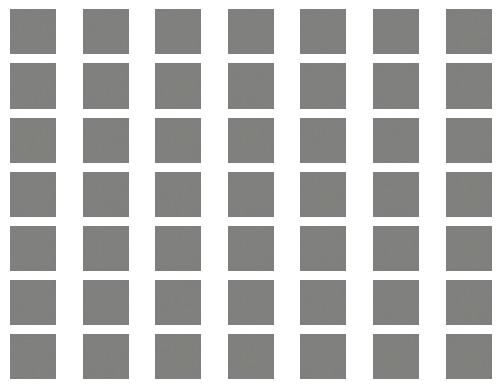

In [59]:
# size of latent space
latent_dim = 100

model = define_generator(latent_dim)

n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)

X = (X+1) / 2.0

for i in range(n_samples):
    pyplot.subplot(7, 7, i+1)
    pyplot.axis('off')
    pyplot.imshow(X[i])
pyplot.show()

# Composite Model

In [62]:
def define_gan(generator_model, discriminator_model):
    discriminator_model.trainable = False
    
    # Connecting them
    model = Sequential()
    model.add(generator_model)
    model.add(discriminator_model)
    
    optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer)
    return model

In [63]:
# Creating the GAN model

latent_dim = 100
discriminator_model = define_discriminator()
generator_model = define_generator(latent_dim)

gan_model = define_gan(generator_model, discriminator_model)

gan_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 32, 32, 3)         1466115   
                                                                 
 sequential_8 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [64]:
plot_model(gan_model, to_file = 'gan_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


![Gan Architecture](gan_architecture.png)

## Training the Composite Model

In [68]:
def train(generator_model, discriminator_model, gan_model, dataset, latent_dim, n_epochs = 200, n_batch = 128):
    batch_per_epoch = int(dataset.shape[0] / n_epochs)
    half_batch = int(n_batch / 2) # half real and half fake
    
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch) # get randomly selected real samples
             
            # update discriminator model weights - 1
            discriminator_loss1, _ = discriminator_model.train_on_batch(X_real, y_real)
            
            #generating fake samples but 'FROM DISCRIMINATOR'
            X_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch) 
            
            # update discriminator model weights - 2
            discriminator_loss2, _ = discriminator_model.train_on_batch(X_fake, y_fake)
            
            # Prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            # Create inverted labels for the fake samples - feeding 1 as label to all generator images to Discriminator
            y_gan = np.ones((n_batch, 1))
            
            # Update the generator via the disciminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            #Summarize loss on this batch
            print('>%d, %d%d, d1 = %.3f, d2 = %.3f, g = %.3f' % 
                  (i+1, j+1, batch_per_epoch, discriminator_loss1, discriminator_loss2, g_loss))
            
        # Randomly evaluating the model performance after 10 epochs
        if (i+1) % 10 == 0:
            summarize_performance(i, generator_model, discriminator_model, dataset, latent_dim)

In [69]:
def summarize_performance(epoch, generator_model, discriminator_model, dataset, latent_dim, n_samples = 150):

    X_real, y_real = generate_real_samples(dataset, n_samples)
    
    _, acc_real = discriminator_model.evaluate(X_real, y_real, verbose = 0)
    
    x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, n_samples)
    
    _, acc_fake = discriminator_model.evaluate(x_fake, y_fake, verbose=0)
    
    # Summarize discriminator's performance
    print('>Accuracy real : %.0f%%, fake : %.0f%%' % (acc_real*100, acc_fake*100))
    
    # Save plot
    save_plot(x_fake, epoch)
    
    #save the generator model title file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    generator_model.save(filename)
    
    
# On every 10 epochs there are 2 things happeneing - 
# 1. Checking the accuracy of discriminator on real and fake data
# 2. Storing and checking the images generated by generator 

In [70]:
# save_plot function
def save_plot(examples, epoch, n = 7):
    # scale from [-1, 1] to [0,1]
    examples = (examples + 1) / 2.0
    
    for i in range(n*n):
        pyplot.subplot(n, n, 1+i)
        pyplot.axis('off')
        pyplot.imshow(examples[i])
    filename = filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

## Did not train this completely !! But results are efficient. 

In [71]:
train(generator_model, discriminator_model, gan_model, dataset, latent_dim, n_epochs = 200, n_batch = 128)

2/2 [==============================] - 0s 10ms/step
>1, 1250, d1 = 0.700, d2 = 0.696, g = 0.691
2/2 [==============================] - 0s 10ms/step
>1, 2250, d1 = 0.630, d2 = 0.700, g = 0.687
2/2 [==============================] - 0s 3ms/step
>1, 3250, d1 = 0.556, d2 = 0.709, g = 0.678
2/2 [==============================] - 0s 5ms/step
>1, 4250, d1 = 0.463, d2 = 0.734, g = 0.656
2/2 [==============================] - 0s 7ms/step
>1, 5250, d1 = 0.362, d2 = 0.787, g = 0.619
2/2 [==============================] - 0s 2ms/step
>1, 6250, d1 = 0.260, d2 = 0.877, g = 0.582
2/2 [==============================] - 0s 5ms/step
>1, 7250, d1 = 0.214, d2 = 0.962, g = 0.567
2/2 [==============================] - 0s 4ms/step
>1, 8250, d1 = 0.218, d2 = 0.942, g = 0.614
2/2 [==============================] - 0s 4ms/step
>1, 9250, d1 = 0.195, d2 = 0.806, g = 0.731
2/2 [==============================] - 0s 3ms/step
>1, 10250, d1 = 0.190, d2 = 0.651, g = 0.869
2/2 [==============================] - 0s 6ms/s

2/2 [==============================] - 0s 4ms/step
>1, 170250, d1 = 0.317, d2 = 0.186, g = 3.215
2/2 [==============================] - 0s 10ms/step
>1, 171250, d1 = 0.410, d2 = 0.263, g = 3.065
2/2 [==============================] - 0s 2ms/step
>1, 172250, d1 = 0.563, d2 = 0.200, g = 2.778
2/2 [==============================] - 0s 3ms/step
>1, 173250, d1 = 0.393, d2 = 0.252, g = 2.931
2/2 [==============================] - 0s 4ms/step
>1, 174250, d1 = 0.472, d2 = 0.190, g = 2.108
2/2 [==============================] - 0s 6ms/step
>1, 175250, d1 = 0.493, d2 = 0.344, g = 1.753
2/2 [==============================] - 0s 4ms/step
>1, 176250, d1 = 0.317, d2 = 0.408, g = 1.859
2/2 [==============================] - 0s 3ms/step
>1, 177250, d1 = 0.284, d2 = 0.278, g = 1.854
2/2 [==============================] - 0s 4ms/step
>1, 178250, d1 = 0.316, d2 = 0.395, g = 1.597
2/2 [==============================] - 0s 5ms/step
>1, 179250, d1 = 0.294, d2 = 0.485, g = 1.608
2/2 [========================

2/2 [==============================] - 0s 6ms/step
>2, 89250, d1 = 0.478, d2 = 0.448, g = 1.835
2/2 [==============================] - 0s 19ms/step
>2, 90250, d1 = 0.429, d2 = 0.271, g = 2.050
2/2 [==============================] - 0s 3ms/step
>2, 91250, d1 = 0.507, d2 = 0.353, g = 2.279
2/2 [==============================] - 0s 11ms/step
>2, 92250, d1 = 0.554, d2 = 0.353, g = 1.941
2/2 [==============================] - 0s 3ms/step
>2, 93250, d1 = 0.435, d2 = 0.335, g = 2.224
2/2 [==============================] - 0s 3ms/step
>2, 94250, d1 = 0.498, d2 = 0.366, g = 2.002
2/2 [==============================] - 0s 24ms/step
>2, 95250, d1 = 0.480, d2 = 0.335, g = 2.123
2/2 [==============================] - 0s 6ms/step
>2, 96250, d1 = 0.420, d2 = 0.380, g = 2.006
2/2 [==============================] - 0s 7ms/step
>2, 97250, d1 = 0.490, d2 = 0.539, g = 2.100
2/2 [==============================] - 0s 7ms/step
>2, 98250, d1 = 0.714, d2 = 0.494, g = 2.117
2/2 [==============================] 

2/2 [==============================] - 0s 4ms/step
>3, 7250, d1 = 0.815, d2 = 0.588, g = 1.410
2/2 [==============================] - 0s 8ms/step
>3, 8250, d1 = 0.659, d2 = 0.668, g = 1.461
2/2 [==============================] - 0s 4ms/step
>3, 9250, d1 = 0.954, d2 = 0.657, g = 1.267
2/2 [==============================] - 0s 3ms/step
>3, 10250, d1 = 0.707, d2 = 0.681, g = 1.314
2/2 [==============================] - 0s 5ms/step
>3, 11250, d1 = 0.797, d2 = 0.567, g = 1.204
2/2 [==============================] - 0s 3ms/step
>3, 12250, d1 = 0.875, d2 = 0.580, g = 1.182
2/2 [==============================] - 0s 5ms/step
>3, 13250, d1 = 0.726, d2 = 0.621, g = 1.181
2/2 [==============================] - 0s 6ms/step
>3, 14250, d1 = 0.676, d2 = 0.585, g = 1.203
2/2 [==============================] - 0s 7ms/step
>3, 15250, d1 = 0.631, d2 = 0.540, g = 1.171
2/2 [==============================] - 0s 4ms/step
>3, 16250, d1 = 0.576, d2 = 0.549, g = 1.214
2/2 [==============================] - 0s 3

2/2 [==============================] - 0s 3ms/step
>3, 176250, d1 = 0.574, d2 = 0.609, g = 1.024
2/2 [==============================] - 0s 3ms/step
>3, 177250, d1 = 0.619, d2 = 0.643, g = 0.994
2/2 [==============================] - 0s 5ms/step
>3, 178250, d1 = 0.548, d2 = 0.599, g = 1.019
2/2 [==============================] - 0s 5ms/step
>3, 179250, d1 = 0.487, d2 = 0.568, g = 1.067
2/2 [==============================] - 0s 3ms/step
>3, 180250, d1 = 0.485, d2 = 0.536, g = 1.139
2/2 [==============================] - 0s 4ms/step
>3, 181250, d1 = 0.498, d2 = 0.499, g = 1.131
2/2 [==============================] - 0s 10ms/step
>3, 182250, d1 = 0.419, d2 = 0.497, g = 1.151
2/2 [==============================] - 0s 10ms/step
>3, 183250, d1 = 0.420, d2 = 0.473, g = 1.140
2/2 [==============================] - 0s 3ms/step
>3, 184250, d1 = 0.420, d2 = 0.523, g = 1.114
2/2 [==============================] - 0s 4ms/step
>3, 185250, d1 = 0.442, d2 = 0.469, g = 1.098
2/2 [=======================

2/2 [==============================] - 0s 20ms/step
>4, 95250, d1 = 0.564, d2 = 0.602, g = 1.116
2/2 [==============================] - 0s 4ms/step
>4, 96250, d1 = 0.543, d2 = 0.605, g = 1.340
2/2 [==============================] - 0s 5ms/step
>4, 97250, d1 = 0.495, d2 = 0.454, g = 1.480
2/2 [==============================] - 0s 3ms/step
>4, 98250, d1 = 0.485, d2 = 0.351, g = 1.648
2/2 [==============================] - 0s 4ms/step
>4, 99250, d1 = 0.490, d2 = 0.311, g = 1.832
2/2 [==============================] - 0s 3ms/step
>4, 100250, d1 = 0.452, d2 = 0.270, g = 1.990
2/2 [==============================] - 0s 4ms/step
>4, 101250, d1 = 0.391, d2 = 0.245, g = 2.077
2/2 [==============================] - 0s 24ms/step
>4, 102250, d1 = 0.346, d2 = 0.226, g = 2.102
2/2 [==============================] - 0s 13ms/step
>4, 103250, d1 = 0.318, d2 = 0.265, g = 2.027
2/2 [==============================] - 0s 4ms/step
>4, 104250, d1 = 0.362, d2 = 0.308, g = 1.982
2/2 [===========================

2/2 [==============================] - 0s 6ms/step
>5, 14250, d1 = 0.481, d2 = 0.411, g = 1.674
2/2 [==============================] - 0s 21ms/step
>5, 15250, d1 = 0.432, d2 = 0.374, g = 1.632
2/2 [==============================] - 0s 11ms/step
>5, 16250, d1 = 0.451, d2 = 0.459, g = 1.650
2/2 [==============================] - 0s 3ms/step
>5, 17250, d1 = 0.421, d2 = 0.505, g = 1.639
2/2 [==============================] - 0s 18ms/step
>5, 18250, d1 = 0.494, d2 = 0.413, g = 1.738
2/2 [==============================] - 0s 3ms/step
>5, 19250, d1 = 0.582, d2 = 0.414, g = 1.577
2/2 [==============================] - 0s 3ms/step
>5, 20250, d1 = 0.434, d2 = 0.436, g = 1.567
2/2 [==============================] - 0s 21ms/step
>5, 21250, d1 = 0.591, d2 = 0.471, g = 1.574
2/2 [==============================] - 0s 5ms/step
>5, 22250, d1 = 0.579, d2 = 0.552, g = 1.617
2/2 [==============================] - 0s 7ms/step
>5, 23250, d1 = 0.552, d2 = 0.429, g = 1.526
2/2 [==============================]

2/2 [==============================] - 0s 6ms/step
>5, 183250, d1 = 0.791, d2 = 0.606, g = 1.382
2/2 [==============================] - 0s 5ms/step
>5, 184250, d1 = 0.692, d2 = 0.538, g = 1.297
2/2 [==============================] - 0s 3ms/step
>5, 185250, d1 = 0.542, d2 = 0.457, g = 1.300
2/2 [==============================] - 0s 4ms/step
>5, 186250, d1 = 0.485, d2 = 0.523, g = 1.337
2/2 [==============================] - 0s 4ms/step
>5, 187250, d1 = 0.631, d2 = 0.512, g = 1.276
2/2 [==============================] - 0s 3ms/step
>5, 188250, d1 = 0.542, d2 = 0.614, g = 1.316
2/2 [==============================] - 0s 7ms/step
>5, 189250, d1 = 0.676, d2 = 0.487, g = 1.266
2/2 [==============================] - 0s 6ms/step
>5, 190250, d1 = 0.432, d2 = 0.562, g = 1.221
2/2 [==============================] - 0s 11ms/step
>5, 191250, d1 = 0.505, d2 = 0.597, g = 1.243
2/2 [==============================] - 0s 6ms/step
>5, 192250, d1 = 0.566, d2 = 0.625, g = 1.148
2/2 [========================

2/2 [==============================] - 0s 3ms/step
>6, 18250, d1 = 0.630, d2 = 0.573, g = 1.145
2/2 [==============================] - 0s 3ms/step
>6, 19250, d1 = 0.860, d2 = 0.731, g = 1.158
2/2 [==============================] - 0s 4ms/step
>6, 20250, d1 = 0.882, d2 = 0.631, g = 1.204
2/2 [==============================] - 0s 3ms/step
>6, 21250, d1 = 0.842, d2 = 0.512, g = 1.305
2/2 [==============================] - 0s 19ms/step
>6, 22250, d1 = 0.787, d2 = 0.486, g = 1.340
2/2 [==============================] - 0s 3ms/step
>6, 23250, d1 = 0.763, d2 = 0.544, g = 1.360
2/2 [==============================] - 0s 8ms/step
>6, 24250, d1 = 0.747, d2 = 0.563, g = 1.344
2/2 [==============================] - 0s 4ms/step
>6, 25250, d1 = 0.617, d2 = 0.495, g = 1.286
2/2 [==============================] - 0s 3ms/step
>6, 26250, d1 = 0.592, d2 = 0.579, g = 1.153
2/2 [==============================] - 0s 5ms/step
>6, 27250, d1 = 0.560, d2 = 0.705, g = 1.087
2/2 [==============================] - 

2/2 [==============================] - 0s 5ms/step
>6, 187250, d1 = 0.644, d2 = 0.744, g = 0.949
2/2 [==============================] - 0s 3ms/step
>6, 188250, d1 = 0.600, d2 = 0.732, g = 0.986
2/2 [==============================] - 0s 3ms/step
>6, 189250, d1 = 0.752, d2 = 0.760, g = 0.914
2/2 [==============================] - 0s 3ms/step
>6, 190250, d1 = 0.665, d2 = 0.737, g = 0.951
2/2 [==============================] - 0s 4ms/step
>6, 191250, d1 = 0.711, d2 = 0.752, g = 0.972
2/2 [==============================] - 0s 7ms/step
>6, 192250, d1 = 0.762, d2 = 0.732, g = 0.950
2/2 [==============================] - 0s 3ms/step
>6, 193250, d1 = 0.675, d2 = 0.654, g = 1.003
2/2 [==============================] - 0s 3ms/step
>6, 194250, d1 = 0.654, d2 = 0.591, g = 1.040
2/2 [==============================] - 0s 6ms/step
>6, 195250, d1 = 0.707, d2 = 0.557, g = 1.105
2/2 [==============================] - 0s 8ms/step
>6, 196250, d1 = 0.593, d2 = 0.575, g = 1.143
2/2 [=========================

2/2 [==============================] - 0s 8ms/step
>7, 107250, d1 = 0.690, d2 = 0.534, g = 1.158
2/2 [==============================] - 0s 2ms/step
>7, 108250, d1 = 0.577, d2 = 0.603, g = 1.090
2/2 [==============================] - 0s 3ms/step
>7, 109250, d1 = 0.697, d2 = 0.642, g = 1.054
2/2 [==============================] - 0s 7ms/step
>7, 110250, d1 = 0.659, d2 = 0.701, g = 1.057
2/2 [==============================] - 0s 2ms/step
>7, 111250, d1 = 0.709, d2 = 0.660, g = 1.049
2/2 [==============================] - 0s 5ms/step
>7, 112250, d1 = 0.713, d2 = 0.590, g = 0.979
2/2 [==============================] - 0s 13ms/step
>7, 113250, d1 = 0.773, d2 = 0.697, g = 0.928
2/2 [==============================] - 0s 4ms/step
>7, 114250, d1 = 0.665, d2 = 0.743, g = 1.020
2/2 [==============================] - 0s 15ms/step
>7, 115250, d1 = 0.743, d2 = 0.630, g = 0.928
2/2 [==============================] - 0s 5ms/step
>7, 116250, d1 = 0.740, d2 = 0.659, g = 0.903
2/2 [=======================

>8, 25250, d1 = 0.427, d2 = 0.580, g = 1.083
2/2 [==============================] - 0s 15ms/step
>8, 26250, d1 = 0.584, d2 = 0.569, g = 1.089
2/2 [==============================] - 0s 9ms/step
>8, 27250, d1 = 0.462, d2 = 0.614, g = 1.161
2/2 [==============================] - 0s 3ms/step
>8, 28250, d1 = 0.579, d2 = 0.554, g = 1.149
2/2 [==============================] - 0s 17ms/step
>8, 29250, d1 = 0.630, d2 = 0.595, g = 1.113
2/2 [==============================] - 0s 4ms/step
>8, 30250, d1 = 0.553, d2 = 0.583, g = 1.155
2/2 [==============================] - 0s 5ms/step
>8, 31250, d1 = 0.530, d2 = 0.524, g = 1.223
2/2 [==============================] - 0s 22ms/step
>8, 32250, d1 = 0.597, d2 = 0.564, g = 1.218
2/2 [==============================] - 0s 15ms/step
>8, 33250, d1 = 0.531, d2 = 0.599, g = 1.214
2/2 [==============================] - 0s 5ms/step
>8, 34250, d1 = 0.525, d2 = 0.556, g = 1.217
2/2 [==============================] - 0s 10ms/step
>8, 35250, d1 = 0.562, d2 = 0.542, 

2/2 [==============================] - 0s 3ms/step
>8, 111250, d1 = 0.579, d2 = 0.608, g = 1.070
2/2 [==============================] - 0s 7ms/step
>8, 112250, d1 = 0.611, d2 = 0.573, g = 1.094
2/2 [==============================] - 0s 2ms/step
>8, 113250, d1 = 0.601, d2 = 0.568, g = 1.070
2/2 [==============================] - 0s 20ms/step
>8, 114250, d1 = 0.539, d2 = 0.537, g = 1.091
2/2 [==============================] - 0s 3ms/step
>8, 115250, d1 = 0.539, d2 = 0.619, g = 1.146
2/2 [==============================] - 0s 3ms/step
>8, 116250, d1 = 0.460, d2 = 0.572, g = 1.132
2/2 [==============================] - 0s 15ms/step
>8, 117250, d1 = 0.568, d2 = 0.500, g = 1.280
2/2 [==============================] - 0s 5ms/step
>8, 118250, d1 = 0.549, d2 = 0.516, g = 1.261
2/2 [==============================] - 0s 18ms/step
>8, 119250, d1 = 0.502, d2 = 0.463, g = 1.331
2/2 [==============================] - 0s 2ms/step
>8, 120250, d1 = 0.422, d2 = 0.476, g = 1.295
2/2 [======================

2/2 [==============================] - 0s 4ms/step
>9, 30250, d1 = 0.615, d2 = 0.472, g = 1.539
2/2 [==============================] - 0s 16ms/step
>9, 31250, d1 = 0.605, d2 = 0.461, g = 1.472
2/2 [==============================] - 0s 22ms/step
>9, 32250, d1 = 0.657, d2 = 0.453, g = 1.446
2/2 [==============================] - 0s 16ms/step
>9, 33250, d1 = 0.643, d2 = 0.436, g = 1.401
2/2 [==============================] - 0s 3ms/step
>9, 34250, d1 = 0.733, d2 = 0.546, g = 1.230
2/2 [==============================] - 0s 8ms/step
>9, 35250, d1 = 0.600, d2 = 0.546, g = 1.231
2/2 [==============================] - 0s 4ms/step
>9, 36250, d1 = 0.668, d2 = 0.619, g = 1.155
2/2 [==============================] - 0s 14ms/step
>9, 37250, d1 = 0.599, d2 = 0.576, g = 1.199
2/2 [==============================] - 0s 5ms/step
>9, 38250, d1 = 0.663, d2 = 0.516, g = 1.237
2/2 [==============================] - 0s 13ms/step
>9, 39250, d1 = 0.669, d2 = 0.608, g = 1.201
2/2 [==============================

2/2 [==============================] - 0s 3ms/step
>9, 115250, d1 = 0.562, d2 = 0.583, g = 1.070
2/2 [==============================] - 0s 5ms/step
>9, 116250, d1 = 0.517, d2 = 0.570, g = 1.192
2/2 [==============================] - 0s 3ms/step
>9, 117250, d1 = 0.555, d2 = 0.535, g = 1.145
2/2 [==============================] - 0s 4ms/step
>9, 118250, d1 = 0.643, d2 = 0.591, g = 1.055
2/2 [==============================] - 0s 3ms/step
>9, 119250, d1 = 0.608, d2 = 0.592, g = 1.003
2/2 [==============================] - 0s 3ms/step
>9, 120250, d1 = 0.530, d2 = 0.551, g = 1.016
2/2 [==============================] - 0s 4ms/step
>9, 121250, d1 = 0.609, d2 = 0.619, g = 1.033
2/2 [==============================] - 0s 3ms/step
>9, 122250, d1 = 0.625, d2 = 0.662, g = 0.962
2/2 [==============================] - 0s 5ms/step
>9, 123250, d1 = 0.649, d2 = 0.594, g = 1.004
2/2 [==============================] - 0s 3ms/step
>9, 124250, d1 = 0.633, d2 = 0.632, g = 0.986
2/2 [=========================

2/2 [==============================] - 0s 7ms/step
>10, 33250, d1 = 0.623, d2 = 0.616, g = 1.071
2/2 [==============================] - 0s 4ms/step
>10, 34250, d1 = 0.600, d2 = 0.659, g = 0.990
2/2 [==============================] - 0s 3ms/step
>10, 35250, d1 = 0.628, d2 = 0.608, g = 1.033
2/2 [==============================] - 0s 12ms/step
>10, 36250, d1 = 0.615, d2 = 0.639, g = 1.042
2/2 [==============================] - 0s 23ms/step
>10, 37250, d1 = 0.646, d2 = 0.630, g = 1.054
2/2 [==============================] - 0s 3ms/step
>10, 38250, d1 = 0.675, d2 = 0.583, g = 1.075
2/2 [==============================] - 0s 3ms/step
>10, 39250, d1 = 0.611, d2 = 0.594, g = 1.135
2/2 [==============================] - 0s 20ms/step
>10, 40250, d1 = 0.639, d2 = 0.519, g = 1.173
2/2 [==============================] - 0s 3ms/step
>10, 41250, d1 = 0.568, d2 = 0.484, g = 1.225
2/2 [==============================] - 0s 3ms/step
>10, 42250, d1 = 0.577, d2 = 0.450, g = 1.243
2/2 [======================

2/2 [==============================] - 0s 2ms/step
>10, 117250, d1 = 0.713, d2 = 0.710, g = 1.020
2/2 [==============================] - 0s 3ms/step
>10, 118250, d1 = 0.610, d2 = 0.562, g = 1.073
2/2 [==============================] - 0s 4ms/step
>10, 119250, d1 = 0.682, d2 = 0.612, g = 1.055
2/2 [==============================] - 0s 3ms/step
>10, 120250, d1 = 0.635, d2 = 0.601, g = 1.070
2/2 [==============================] - 0s 3ms/step
>10, 121250, d1 = 0.579, d2 = 0.562, g = 1.062
2/2 [==============================] - 0s 3ms/step
>10, 122250, d1 = 0.590, d2 = 0.553, g = 1.082
2/2 [==============================] - 0s 3ms/step
>10, 123250, d1 = 0.555, d2 = 0.566, g = 1.065
2/2 [==============================] - 0s 3ms/step
>10, 124250, d1 = 0.680, d2 = 0.606, g = 1.004
2/2 [==============================] - 0s 3ms/step
>10, 125250, d1 = 0.516, d2 = 0.639, g = 1.030
2/2 [==============================] - 0s 3ms/step
>10, 126250, d1 = 0.557, d2 = 0.562, g = 1.105
2/2 [===============

2/2 [==============================] - 0s 7ms/step
>11, 31250, d1 = 0.629, d2 = 0.627, g = 0.964
2/2 [==============================] - 0s 5ms/step
>11, 32250, d1 = 0.743, d2 = 0.615, g = 0.998
2/2 [==============================] - 0s 4ms/step
>11, 33250, d1 = 0.717, d2 = 0.606, g = 1.010
2/2 [==============================] - 0s 3ms/step
>11, 34250, d1 = 0.700, d2 = 0.656, g = 1.001
2/2 [==============================] - 0s 9ms/step
>11, 35250, d1 = 0.681, d2 = 0.597, g = 1.049
2/2 [==============================] - 0s 3ms/step
>11, 36250, d1 = 0.689, d2 = 0.522, g = 1.019
2/2 [==============================] - 0s 20ms/step
>11, 37250, d1 = 0.679, d2 = 0.593, g = 1.058
2/2 [==============================] - 0s 21ms/step
>11, 38250, d1 = 0.688, d2 = 0.582, g = 1.078
2/2 [==============================] - 0s 9ms/step
>11, 39250, d1 = 0.680, d2 = 0.571, g = 1.054
2/2 [==============================] - 0s 10ms/step
>11, 40250, d1 = 0.681, d2 = 0.611, g = 1.073
2/2 [======================

2/2 [==============================] - 0s 5ms/step
>11, 198250, d1 = 0.579, d2 = 0.636, g = 1.006
2/2 [==============================] - 0s 3ms/step
>11, 199250, d1 = 0.657, d2 = 0.591, g = 0.995
2/2 [==============================] - 0s 3ms/step
>11, 200250, d1 = 0.679, d2 = 0.639, g = 0.949
2/2 [==============================] - 0s 3ms/step
>11, 201250, d1 = 0.634, d2 = 0.672, g = 0.927
2/2 [==============================] - 0s 3ms/step
>11, 202250, d1 = 0.543, d2 = 0.620, g = 0.993
2/2 [==============================] - 0s 3ms/step
>11, 203250, d1 = 0.696, d2 = 0.677, g = 0.962
2/2 [==============================] - 0s 8ms/step
>11, 204250, d1 = 0.667, d2 = 0.581, g = 1.003
2/2 [==============================] - 0s 5ms/step
>11, 205250, d1 = 0.659, d2 = 0.714, g = 1.035
2/2 [==============================] - 0s 2ms/step
>11, 206250, d1 = 0.693, d2 = 0.592, g = 1.100
2/2 [==============================] - 0s 21ms/step
>11, 207250, d1 = 0.708, d2 = 0.600, g = 1.047
2/2 [==============

2/2 [==============================] - 0s 3ms/step
>12, 32250, d1 = 0.589, d2 = 0.510, g = 1.169
2/2 [==============================] - 0s 23ms/step
>12, 33250, d1 = 0.516, d2 = 0.549, g = 1.143
2/2 [==============================] - 0s 20ms/step
>12, 34250, d1 = 0.558, d2 = 0.524, g = 1.080
2/2 [==============================] - 0s 22ms/step
>12, 35250, d1 = 0.495, d2 = 0.575, g = 1.039
2/2 [==============================] - 0s 3ms/step
>12, 36250, d1 = 0.541, d2 = 0.576, g = 1.136
2/2 [==============================] - 0s 3ms/step
>12, 37250, d1 = 0.548, d2 = 0.616, g = 1.121
2/2 [==============================] - 0s 5ms/step
>12, 38250, d1 = 0.528, d2 = 0.675, g = 1.094
2/2 [==============================] - 0s 4ms/step
>12, 39250, d1 = 0.521, d2 = 0.621, g = 1.103
2/2 [==============================] - 0s 8ms/step
>12, 40250, d1 = 0.545, d2 = 0.598, g = 1.197
2/2 [==============================] - 0s 6ms/step
>12, 41250, d1 = 0.652, d2 = 0.585, g = 1.147
2/2 [======================

2/2 [==============================] - 0s 7ms/step
>12, 199250, d1 = 0.717, d2 = 0.541, g = 1.347
2/2 [==============================] - 0s 7ms/step
>12, 200250, d1 = 0.722, d2 = 0.501, g = 1.311
2/2 [==============================] - 0s 15ms/step
>12, 201250, d1 = 0.665, d2 = 0.538, g = 1.225
2/2 [==============================] - 0s 3ms/step
>12, 202250, d1 = 0.768, d2 = 0.598, g = 1.210
2/2 [==============================] - 0s 8ms/step
>12, 203250, d1 = 0.709, d2 = 0.614, g = 1.104
2/2 [==============================] - 0s 11ms/step
>12, 204250, d1 = 0.592, d2 = 0.664, g = 1.169
2/2 [==============================] - 0s 3ms/step
>12, 205250, d1 = 0.627, d2 = 0.599, g = 1.276
2/2 [==============================] - 0s 3ms/step
>12, 206250, d1 = 0.731, d2 = 0.524, g = 1.248
2/2 [==============================] - 0s 3ms/step
>12, 207250, d1 = 0.661, d2 = 0.487, g = 1.212
2/2 [==============================] - 0s 18ms/step
>12, 208250, d1 = 0.677, d2 = 0.512, g = 1.174
2/2 [============

2/2 [==============================] - 0s 6ms/step
>13, 117250, d1 = 0.684, d2 = 0.568, g = 1.143
2/2 [==============================] - 0s 23ms/step
>13, 118250, d1 = 0.662, d2 = 0.588, g = 1.096
2/2 [==============================] - 0s 18ms/step
>13, 119250, d1 = 0.669, d2 = 0.786, g = 1.135
2/2 [==============================] - 0s 3ms/step
>13, 120250, d1 = 0.703, d2 = 0.785, g = 1.200
2/2 [==============================] - 0s 3ms/step
>13, 121250, d1 = 0.591, d2 = 0.559, g = 1.230
2/2 [==============================] - 0s 22ms/step
>13, 122250, d1 = 0.764, d2 = 0.486, g = 1.195
2/2 [==============================] - 0s 3ms/step
>13, 123250, d1 = 0.738, d2 = 0.554, g = 1.090
2/2 [==============================] - 0s 7ms/step
>13, 124250, d1 = 0.776, d2 = 0.630, g = 1.083
2/2 [==============================] - 0s 3ms/step
>13, 125250, d1 = 0.630, d2 = 0.610, g = 1.134
2/2 [==============================] - 0s 8ms/step
>13, 126250, d1 = 0.690, d2 = 0.569, g = 1.201
2/2 [============

2/2 [==============================] - 0s 3ms/step
>14, 34250, d1 = 0.592, d2 = 0.557, g = 1.109
2/2 [==============================] - 0s 7ms/step
>14, 35250, d1 = 0.592, d2 = 0.516, g = 1.147
2/2 [==============================] - 0s 3ms/step
>14, 36250, d1 = 0.484, d2 = 0.497, g = 1.079
2/2 [==============================] - 0s 4ms/step
>14, 37250, d1 = 0.563, d2 = 0.544, g = 1.107
2/2 [==============================] - 0s 5ms/step
>14, 38250, d1 = 0.527, d2 = 0.631, g = 1.132
2/2 [==============================] - 0s 6ms/step
>14, 39250, d1 = 0.485, d2 = 0.571, g = 1.092
2/2 [==============================] - 0s 11ms/step
>14, 40250, d1 = 0.547, d2 = 0.554, g = 1.121
2/2 [==============================] - 0s 5ms/step
>14, 41250, d1 = 0.630, d2 = 0.612, g = 1.099
2/2 [==============================] - 0s 3ms/step
>14, 42250, d1 = 0.704, d2 = 0.636, g = 1.083
2/2 [==============================] - 0s 8ms/step
>14, 43250, d1 = 0.648, d2 = 0.648, g = 1.239
2/2 [========================

2/2 [==============================] - 0s 3ms/step
>14, 118250, d1 = 0.692, d2 = 0.586, g = 1.023
2/2 [==============================] - 0s 7ms/step
>14, 119250, d1 = 0.609, d2 = 0.601, g = 1.044
2/2 [==============================] - 0s 4ms/step
>14, 120250, d1 = 0.700, d2 = 0.686, g = 1.060
2/2 [==============================] - 0s 4ms/step
>14, 121250, d1 = 0.656, d2 = 0.556, g = 1.066
2/2 [==============================] - 0s 3ms/step
>14, 122250, d1 = 0.532, d2 = 0.516, g = 1.017
2/2 [==============================] - 0s 5ms/step
>14, 123250, d1 = 0.510, d2 = 0.601, g = 1.129
2/2 [==============================] - 0s 7ms/step
>14, 124250, d1 = 0.547, d2 = 0.573, g = 1.190
2/2 [==============================] - 0s 21ms/step
>14, 125250, d1 = 0.520, d2 = 0.582, g = 1.128
2/2 [==============================] - 0s 10ms/step
>14, 126250, d1 = 0.531, d2 = 0.686, g = 1.112
2/2 [==============================] - 0s 2ms/step
>14, 127250, d1 = 0.615, d2 = 0.687, g = 1.179
2/2 [=============

2/2 [==============================] - 0s 3ms/step
>15, 35250, d1 = 0.650, d2 = 0.555, g = 1.189
2/2 [==============================] - 0s 3ms/step
>15, 36250, d1 = 0.641, d2 = 0.581, g = 1.135
2/2 [==============================] - 0s 12ms/step
>15, 37250, d1 = 0.592, d2 = 0.632, g = 1.140
2/2 [==============================] - 0s 20ms/step
>15, 38250, d1 = 0.661, d2 = 0.544, g = 1.209
2/2 [==============================] - 0s 3ms/step
>15, 39250, d1 = 0.539, d2 = 0.482, g = 1.208
2/2 [==============================] - 0s 5ms/step
>15, 40250, d1 = 0.540, d2 = 0.537, g = 1.108
2/2 [==============================] - 0s 4ms/step
>15, 41250, d1 = 0.587, d2 = 0.579, g = 1.086
2/2 [==============================] - 0s 20ms/step
>15, 42250, d1 = 0.474, d2 = 0.642, g = 1.086
2/2 [==============================] - 0s 3ms/step
>15, 43250, d1 = 0.578, d2 = 0.563, g = 1.176
2/2 [==============================] - 0s 22ms/step
>15, 44250, d1 = 0.708, d2 = 0.623, g = 1.099
2/2 [=====================

2/2 [==============================] - 0s 18ms/step
>15, 202250, d1 = 0.553, d2 = 0.495, g = 1.182
2/2 [==============================] - 0s 3ms/step
>15, 203250, d1 = 0.512, d2 = 0.502, g = 1.277
2/2 [==============================] - 0s 3ms/step
>15, 204250, d1 = 0.540, d2 = 0.522, g = 1.137
2/2 [==============================] - 0s 4ms/step
>15, 205250, d1 = 0.457, d2 = 0.630, g = 1.151
2/2 [==============================] - 0s 8ms/step
>15, 206250, d1 = 0.513, d2 = 0.553, g = 1.173
2/2 [==============================] - 0s 21ms/step
>15, 207250, d1 = 0.603, d2 = 0.577, g = 1.221
2/2 [==============================] - 0s 3ms/step
>15, 208250, d1 = 0.673, d2 = 0.616, g = 1.123
2/2 [==============================] - 0s 3ms/step
>15, 209250, d1 = 0.596, d2 = 0.671, g = 1.120
2/2 [==============================] - 0s 3ms/step
>15, 210250, d1 = 0.589, d2 = 0.631, g = 1.184
2/2 [==============================] - 0s 16ms/step
>15, 211250, d1 = 0.618, d2 = 0.625, g = 1.225
2/2 [============

2/2 [==============================] - 0s 6ms/step
>16, 36250, d1 = 0.522, d2 = 0.480, g = 1.211
2/2 [==============================] - 0s 3ms/step
>16, 37250, d1 = 0.517, d2 = 0.500, g = 1.215
2/2 [==============================] - 0s 8ms/step
>16, 38250, d1 = 0.520, d2 = 0.494, g = 1.165
2/2 [==============================] - 0s 3ms/step
>16, 39250, d1 = 0.426, d2 = 0.568, g = 1.213
2/2 [==============================] - 0s 6ms/step
>16, 40250, d1 = 0.539, d2 = 0.511, g = 1.241
2/2 [==============================] - 0s 5ms/step
>16, 41250, d1 = 0.568, d2 = 0.499, g = 1.217
2/2 [==============================] - 0s 14ms/step
>16, 42250, d1 = 0.509, d2 = 0.486, g = 1.151
2/2 [==============================] - 0s 21ms/step
>16, 43250, d1 = 0.464, d2 = 0.511, g = 1.220
2/2 [==============================] - 0s 19ms/step
>16, 44250, d1 = 0.558, d2 = 0.624, g = 1.229
2/2 [==============================] - 0s 13ms/step
>16, 45250, d1 = 0.530, d2 = 0.540, g = 1.236
2/2 [=====================

2/2 [==============================] - 0s 4ms/step
>16, 204250, d1 = 0.665, d2 = 0.602, g = 1.140
2/2 [==============================] - 0s 3ms/step
>16, 205250, d1 = 0.650, d2 = 0.616, g = 1.147
2/2 [==============================] - 0s 3ms/step
>16, 206250, d1 = 0.773, d2 = 0.669, g = 1.167
2/2 [==============================] - 0s 5ms/step
>16, 207250, d1 = 0.641, d2 = 0.529, g = 1.168
2/2 [==============================] - 0s 3ms/step
>16, 208250, d1 = 0.623, d2 = 0.569, g = 1.204
2/2 [==============================] - 0s 11ms/step
>16, 209250, d1 = 0.584, d2 = 0.623, g = 1.247
2/2 [==============================] - 0s 3ms/step
>16, 210250, d1 = 0.509, d2 = 0.506, g = 1.220
2/2 [==============================] - 0s 4ms/step
>16, 211250, d1 = 0.552, d2 = 0.502, g = 1.208
2/2 [==============================] - 0s 2ms/step
>16, 212250, d1 = 0.529, d2 = 0.519, g = 1.209
2/2 [==============================] - 0s 3ms/step
>16, 213250, d1 = 0.566, d2 = 0.781, g = 1.220
2/2 [==============

2/2 [==============================] - 0s 4ms/step
>17, 38250, d1 = 0.605, d2 = 0.402, g = 1.287
2/2 [==============================] - 0s 3ms/step
>17, 39250, d1 = 0.595, d2 = 0.511, g = 1.342
2/2 [==============================] - 0s 4ms/step
>17, 40250, d1 = 0.494, d2 = 0.475, g = 1.330
2/2 [==============================] - 0s 3ms/step
>17, 41250, d1 = 0.647, d2 = 0.504, g = 1.257
2/2 [==============================] - 0s 3ms/step
>17, 42250, d1 = 0.544, d2 = 0.492, g = 1.217
2/2 [==============================] - 0s 5ms/step
>17, 43250, d1 = 0.495, d2 = 0.535, g = 1.224
2/2 [==============================] - 0s 3ms/step
>17, 44250, d1 = 0.634, d2 = 0.600, g = 1.224
2/2 [==============================] - 0s 4ms/step
>17, 45250, d1 = 0.703, d2 = 0.665, g = 1.221
2/2 [==============================] - 0s 5ms/step
>17, 46250, d1 = 0.690, d2 = 0.544, g = 1.217
2/2 [==============================] - 0s 3ms/step
>17, 47250, d1 = 0.704, d2 = 0.603, g = 1.281
2/2 [=========================

2/2 [==============================] - 0s 4ms/step
>17, 206250, d1 = 0.646, d2 = 0.767, g = 0.952
2/2 [==============================] - 0s 4ms/step
>17, 207250, d1 = 0.708, d2 = 0.657, g = 0.977
2/2 [==============================] - 0s 3ms/step
>17, 208250, d1 = 0.629, d2 = 0.673, g = 1.041
2/2 [==============================] - 0s 3ms/step
>17, 209250, d1 = 0.659, d2 = 0.586, g = 1.017
2/2 [==============================] - 0s 4ms/step
>17, 210250, d1 = 0.605, d2 = 0.676, g = 0.971
2/2 [==============================] - 0s 3ms/step
>17, 211250, d1 = 0.585, d2 = 0.610, g = 0.867
2/2 [==============================] - 0s 4ms/step
>17, 212250, d1 = 0.546, d2 = 0.638, g = 0.859
2/2 [==============================] - 0s 3ms/step
>17, 213250, d1 = 0.525, d2 = 0.679, g = 1.009
2/2 [==============================] - 0s 3ms/step
>17, 214250, d1 = 0.623, d2 = 0.689, g = 0.980
2/2 [==============================] - 0s 4ms/step
>17, 215250, d1 = 0.603, d2 = 0.588, g = 1.034
2/2 [===============

2/2 [==============================] - 0s 3ms/step
>18, 124250, d1 = 0.676, d2 = 0.688, g = 0.886
2/2 [==============================] - 0s 3ms/step
>18, 125250, d1 = 0.654, d2 = 0.672, g = 0.919
2/2 [==============================] - 0s 3ms/step
>18, 126250, d1 = 0.677, d2 = 0.730, g = 0.996
2/2 [==============================] - 0s 4ms/step
>18, 127250, d1 = 0.737, d2 = 0.601, g = 0.934
2/2 [==============================] - 0s 3ms/step
>18, 128250, d1 = 0.711, d2 = 0.623, g = 0.906
2/2 [==============================] - 0s 4ms/step
>18, 129250, d1 = 0.669, d2 = 0.647, g = 0.885
2/2 [==============================] - 0s 3ms/step
>18, 130250, d1 = 0.665, d2 = 0.609, g = 0.862
2/2 [==============================] - 0s 4ms/step
>18, 131250, d1 = 0.619, d2 = 0.651, g = 0.954
2/2 [==============================] - 0s 4ms/step
>18, 132250, d1 = 0.710, d2 = 0.648, g = 0.854
2/2 [==============================] - 0s 3ms/step
>18, 133250, d1 = 0.628, d2 = 0.728, g = 0.911
2/2 [===============

2/2 [==============================] - 0s 3ms/step
>18, 208250, d1 = 0.628, d2 = 0.596, g = 0.903
2/2 [==============================] - 0s 4ms/step
>18, 209250, d1 = 0.614, d2 = 0.665, g = 0.867
2/2 [==============================] - 0s 3ms/step
>18, 210250, d1 = 0.588, d2 = 0.618, g = 0.929
2/2 [==============================] - 0s 3ms/step
>18, 211250, d1 = 0.644, d2 = 0.643, g = 0.920
2/2 [==============================] - 0s 4ms/step
>18, 212250, d1 = 0.713, d2 = 0.621, g = 0.900
2/2 [==============================] - 0s 3ms/step
>18, 213250, d1 = 0.644, d2 = 0.626, g = 0.930
2/2 [==============================] - 0s 2ms/step
>18, 214250, d1 = 0.665, d2 = 0.639, g = 0.892
2/2 [==============================] - 0s 3ms/step
>18, 215250, d1 = 0.640, d2 = 0.662, g = 0.865
2/2 [==============================] - 0s 3ms/step
>18, 216250, d1 = 0.607, d2 = 0.692, g = 0.846
2/2 [==============================] - 0s 7ms/step
>18, 217250, d1 = 0.726, d2 = 0.594, g = 0.882
2/2 [===============

2/2 [==============================] - 0s 4ms/step
>19, 126250, d1 = 0.664, d2 = 0.642, g = 0.867
2/2 [==============================] - 0s 3ms/step
>19, 127250, d1 = 0.676, d2 = 0.664, g = 0.857
2/2 [==============================] - 0s 3ms/step
>19, 128250, d1 = 0.682, d2 = 0.710, g = 0.863
2/2 [==============================] - 0s 3ms/step
>19, 129250, d1 = 0.578, d2 = 0.717, g = 0.904
2/2 [==============================] - 0s 4ms/step
>19, 130250, d1 = 0.684, d2 = 0.609, g = 0.941
2/2 [==============================] - 0s 3ms/step
>19, 131250, d1 = 0.664, d2 = 0.647, g = 0.901
2/2 [==============================] - 0s 6ms/step
>19, 132250, d1 = 0.701, d2 = 0.656, g = 0.914
2/2 [==============================] - 0s 2ms/step
>19, 133250, d1 = 0.704, d2 = 0.589, g = 0.914
2/2 [==============================] - 0s 4ms/step
>19, 134250, d1 = 0.668, d2 = 0.638, g = 0.897
2/2 [==============================] - 0s 4ms/step
>19, 135250, d1 = 0.629, d2 = 0.582, g = 0.882
2/2 [===============

2/2 [==============================] - 0s 4ms/step
>19, 210250, d1 = 0.627, d2 = 0.674, g = 0.872
2/2 [==============================] - 0s 3ms/step
>19, 211250, d1 = 0.606, d2 = 0.718, g = 0.893
2/2 [==============================] - 0s 3ms/step
>19, 212250, d1 = 0.644, d2 = 0.644, g = 0.854
2/2 [==============================] - 0s 6ms/step
>19, 213250, d1 = 0.695, d2 = 0.586, g = 0.894
2/2 [==============================] - 0s 5ms/step
>19, 214250, d1 = 0.654, d2 = 0.692, g = 0.892
2/2 [==============================] - 0s 3ms/step
>19, 215250, d1 = 0.747, d2 = 0.709, g = 0.927
2/2 [==============================] - 0s 4ms/step
>19, 216250, d1 = 0.725, d2 = 0.625, g = 0.935
2/2 [==============================] - 0s 3ms/step
>19, 217250, d1 = 0.751, d2 = 0.601, g = 0.896
2/2 [==============================] - 0s 2ms/step
>19, 218250, d1 = 0.722, d2 = 0.611, g = 0.958
2/2 [==============================] - 0s 3ms/step
>19, 219250, d1 = 0.724, d2 = 0.652, g = 0.848
2/2 [===============

2/2 [==============================] - 0s 3ms/step
>20, 128250, d1 = 0.640, d2 = 0.650, g = 0.875
2/2 [==============================] - 0s 7ms/step
>20, 129250, d1 = 0.585, d2 = 0.631, g = 0.863
2/2 [==============================] - 0s 8ms/step
>20, 130250, d1 = 0.643, d2 = 0.697, g = 0.897
2/2 [==============================] - 0s 3ms/step
>20, 131250, d1 = 0.637, d2 = 0.633, g = 0.834
2/2 [==============================] - 0s 20ms/step
>20, 132250, d1 = 0.628, d2 = 0.667, g = 0.851
2/2 [==============================] - 0s 5ms/step
>20, 133250, d1 = 0.624, d2 = 0.650, g = 0.856
2/2 [==============================] - 0s 3ms/step
>20, 134250, d1 = 0.621, d2 = 0.709, g = 0.809
2/2 [==============================] - 0s 6ms/step
>20, 135250, d1 = 0.641, d2 = 0.712, g = 0.870
2/2 [==============================] - 0s 24ms/step
>20, 136250, d1 = 0.682, d2 = 0.694, g = 0.934
2/2 [==============================] - 0s 3ms/step
>20, 137250, d1 = 0.680, d2 = 0.544, g = 0.997
2/2 [=============

2/2 [==============================] - 0s 16ms/step
>21, 42250, d1 = 0.690, d2 = 0.443, g = 1.406
2/2 [==============================] - 0s 5ms/step
>21, 43250, d1 = 0.726, d2 = 0.484, g = 1.091
2/2 [==============================] - 0s 5ms/step
>21, 44250, d1 = 0.584, d2 = 0.724, g = 0.901
2/2 [==============================] - 0s 9ms/step
>21, 45250, d1 = 0.578, d2 = 0.601, g = 0.934
2/2 [==============================] - 0s 5ms/step
>21, 46250, d1 = 0.502, d2 = 0.756, g = 0.925
2/2 [==============================] - 0s 20ms/step
>21, 47250, d1 = 0.637, d2 = 0.582, g = 1.006
2/2 [==============================] - 0s 8ms/step
>21, 48250, d1 = 0.627, d2 = 0.628, g = 0.985
2/2 [==============================] - 0s 8ms/step
>21, 49250, d1 = 0.485, d2 = 0.858, g = 0.928
2/2 [==============================] - 0s 3ms/step
>21, 50250, d1 = 0.555, d2 = 0.748, g = 0.976
2/2 [==============================] - 0s 10ms/step
>21, 51250, d1 = 0.674, d2 = 0.676, g = 0.908
2/2 [======================

KeyboardInterrupt: 